# Imports

In [ ]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.5.3


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00
time: 350 µs (started: 2023-02-25 12:16:47 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, 
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.77 s (started: 2023-02-25 12:16:47 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'ResNet152V2'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' 

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/' \
            + TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/regular_otsu/

versión Keras: 2.11.0
time: 1.54 ms (started: 2023-02-25 12:16:50 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 1min 12s (started: 2023-02-25 12:16:50 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet152V2_9G = keras.applications.ResNet152V2(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet152V2_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG):
    '''Guardar el modelo en disco duro.
    Debe especificarse la ruta porque por defecto la guarda
    en el la memoria de la misma instancia de Google Colab.
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG = regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME= Deep Neural Network's name, like ResNet152V2.
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/otsu_reg/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)
    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 8.51 ms (started: 2023-02-25 12:18:03 +00:00)


# Imgs 64x64

- Test Accuracy: 0.45905566215515137
- Test Loss: 3.160655975341797
- time: 5h 14min 24s
- F1 score: 0.45791157403780836
- Precision score: 0.47807294351142815
- Recall:  0.4590556492411467
- Epoch: 50/50


## Cargar la imágenes

In [ ]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/regular_otsu/
time: 1.21 ms (started: 2023-02-24 14:18:38 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 12.7 s (started: 2023-02-24 14:18:38 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.08 ms (started: 2023-02-24 14:18:51 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 7s 0us/step
time: 14.3 s (started: 2023-02-24 14:18:51 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 402s 28ms/step - loss: 6.0749 - sparse_categorical_accuracy: 0.1002 - val_loss: 5.2925 - val_sparse_categorical_accuracy: 0.1692
Epoch 2/50
13899/13899 [==============================] - 377s 27ms/step - loss: 4.6923 - sparse_categorical_accuracy: 0.2389 - val_loss: 4.6578 - val_sparse_categorical_accuracy: 0.2359
Epoch 3/50
13899/13899 [==============================] - 377s 27ms/step - loss: 4.0707 - sparse_categorical_accuracy: 0.3134 - val_loss: 4.2954 - val_sparse_categorical_accuracy: 0.2782
Epoch 4/50
13899/13899 [==============================] - 383s 28ms/step - loss: 3.6583 - sparse_categorical_accuracy: 0.3667 - val_loss: 4.0464 - val_sparse_categorical_accuracy: 0.3078
Epoch 5/50
13899/13899 [==============================] - 385s 28ms/step - loss: 3.3525 - sparse_categorical_accuracy: 0.4075 - val_loss: 3.8670 - val_sparse_categorical_accuracy: 0.3297
Epoch 6/50
13899/13899 [==============================] - 383s 28

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.93 s (started: 2023-02-24 19:33:32 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 44s 22ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.45905566215515137
- Test Loss: 3.160655975341797
- time: 
- F1 score: 0.45791157403780836
- Precision score: 0.47807294351142815
- Recall:  0.4590556492411467
- Epoch: 
*********************************************************************************************************************************
time: 1min 30s (started: 2023-02-24 19:33:34 +00:00)


## Graficando

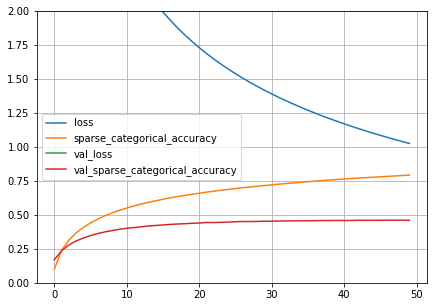

time: 232 ms (started: 2023-02-24 19:35:04 +00:00)


In [ ]:
plot_loss(history)

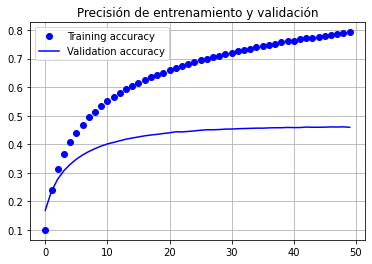

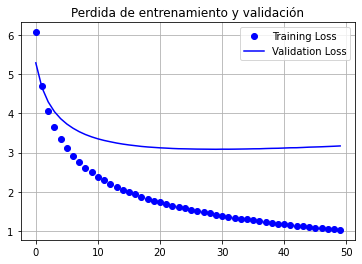

time: 261 ms (started: 2023-02-24 19:35:05 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/model_resnet152v2_etl9_imgs64_regular__OTSU.h5
time: 2.76 s (started: 2023-02-24 19:35:05 +00:00)


# Imgs 96x96

- Test Accuracy: 0.5721416473388672
- Test Loss: 2.424877643585205
- time: 5h 36min 17s
- F1 score: 0.5723042025496293
- Precision score: 0.5925072813445152
- Recall:  0.572141652613828
- Epoch: 50/50


## Cargar las imágenes

In [ ]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_96/splits/regular_otsu/
time: 810 µs (started: 2023-02-24 19:36:40 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 16.9 s (started: 2023-02-24 19:36:41 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 1.34 ms (started: 2023-02-24 19:36:58 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.54 s (started: 2023-02-24 19:36:58 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 413s 29ms/step - loss: 6.1746 - sparse_categorical_accuracy: 0.1076 - val_loss: 5.3523 - val_sparse_categorical_accuracy: 0.1847
Epoch 2/50
13899/13899 [==============================] - 397s 29ms/step - loss: 4.7411 - sparse_categorical_accuracy: 0.2647 - val_loss: 4.6287 - val_sparse_categorical_accuracy: 0.2659
Epoch 3/50
13899/13899 [==============================] - 397s 29ms/step - loss: 4.0515 - sparse_categorical_accuracy: 0.3514 - val_loss: 4.1897 - val_sparse_categorical_accuracy: 0.3182
Epoch 4/50
13899/13899 [==============================] - 396s 29ms/step - loss: 3.5840 - sparse_categorical_accuracy: 0.4136 - val_loss: 3.8822 - val_sparse_categorical_accuracy: 0.3564
Epoch 5/50
13899/13899 [==============================] - 396s 29ms/step - loss: 3.2350 - sparse_categorical_accuracy: 0.4615 - val_loss: 3.6537 - val_sparse_categorical_accuracy: 0.3860
Epoch 6/50
13899/13899 [==============================] - 398s 29

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.39 s (started: 2023-02-25 01:13:22 +00:00)


## Métricas

In [ ]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 46s 23ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5721416473388672
- Test Loss: 2.424877643585205
- time: 
- F1 score: 0.5723042025496293
- Precision score: 0.5925072813445152
- Recall:  0.572141652613828
- Epoch: 
*********************************************************************************************************************************
time: 1min 34s (started: 2023-02-25 01:13:25 +00:00)


## Graficando

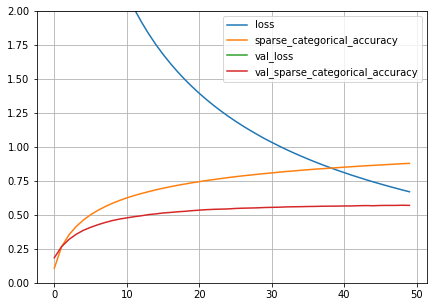

time: 161 ms (started: 2023-02-25 01:14:59 +00:00)


In [ ]:
plot_loss(history)

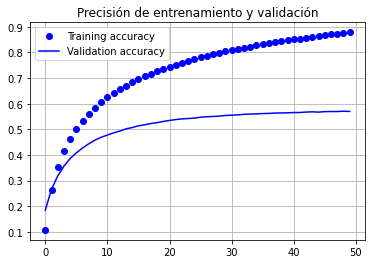

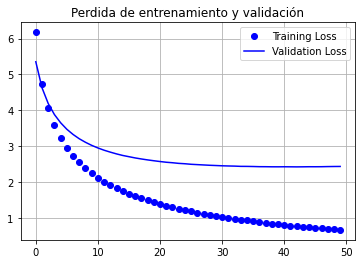

time: 257 ms (started: 2023-02-25 01:14:59 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/otsu_reg/model_resnet152v2_etl9_imgs96_regular__OTSU.h5
time: 2.39 s (started: 2023-02-25 01:14:59 +00:00)


# Imgs 112x112

- Test Accuracy: 0.6155649423599243
- Test Loss: 2.0923264026641846
- time: 6h 4min 27s
- F1 score: 0.6165265567566738
- Precision score: 0.637013599897153
- Recall:  0.6155649241146711
- Epoch: 50/50



## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_112/splits/regular_otsu/
time: 862 µs (started: 2023-02-25 12:18:15 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 21 s (started: 2023-02-25 12:18:15 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.28 ms (started: 2023-02-25 12:18:36 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 1s 0us/step
time: 8.9 s (started: 2023-02-25 12:18:36 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 112, 112, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate[0][0]']        

## Entrenar modelo


In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 460s 32ms/step - loss: 5.8746 - sparse_categorical_accuracy: 0.1320 - val_loss: 4.9613 - val_sparse_categorical_accuracy: 0.2266
Epoch 2/50
13899/13899 [==============================] - 433s 31ms/step - loss: 4.3141 - sparse_categorical_accuracy: 0.3114 - val_loss: 4.1788 - val_sparse_categorical_accuracy: 0.3161
Epoch 3/50
13899/13899 [==============================] - 432s 31ms/step - loss: 3.5876 - sparse_categorical_accuracy: 0.4081 - val_loss: 3.7155 - val_sparse_categorical_accuracy: 0.3760
Epoch 4/50
13899/13899 [==============================] - 435s 31ms/step - loss: 3.1082 - sparse_categorical_accuracy: 0.4765 - val_loss: 3.4000 - val_sparse_categorical_accuracy: 0.4145
Epoch 5/50
13899/13899 [==============================] - 437s 31ms/step - loss: 2.7569 - sparse_categorical_accuracy: 0.5274 - val_loss: 3.1668 - val_sparse_categorical_accuracy: 0.4469
Epoch 6/50
13899/13899 [==============================] - 442s 32

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.68 s (started: 2023-02-25 18:23:14 +00:00)


In [19]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 47s 26ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6155649423599243
- Test Loss: 2.0923264026641846
- time: 
- F1 score: 0.6165265567566738
- Precision score: 0.637013599897153
- Recall:  0.6155649241146711
- Epoch: 
*********************************************************************************************************************************
time: 1min 40s (started: 2023-02-25 18:47:03 +00:00)


## Graficando

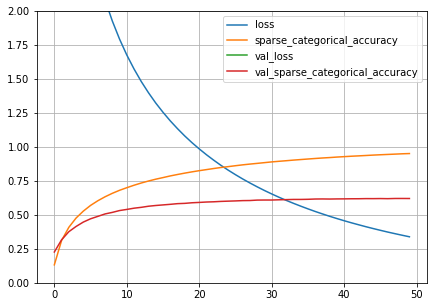

time: 305 ms (started: 2023-02-25 18:25:01 +00:00)


In [ ]:
plot_loss(history)

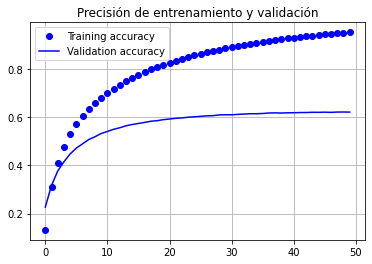

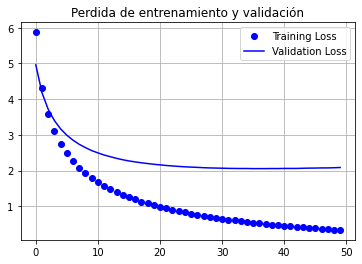

time: 240 ms (started: 2023-02-25 18:25:01 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

# Imgs 127x127

- Test Accuracy: 0.6925126314163208
- Test Loss: 1.7104483842849731
- time: 7h 27min 1s
- F1 score: 0.6938810277819452
- Precision score: 0.7118398991897091
- Recall:  0.692512647554806
- Epoch: 50/50



## Cargar imágenes

In [21]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/regular_otsu/
time: 841 µs (started: 2023-02-25 18:49:29 +00:00)


In [22]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 24.8 s (started: 2023-02-25 18:49:29 +00:00)


In [23]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 127, 127, 1) and labels: (444750,)

- val images: (88950, 127, 127, 1) and labels: (88950,)

time: 1.15 ms (started: 2023-02-25 18:49:54 +00:00)


## Preparar el modelo

In [24]:
custom_model2 = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.44 s (started: 2023-02-25 18:49:54 +00:00)


In [25]:
print(custom_model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 127, 127, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate_1[0][0]']    

## Entrenar modelo

In [26]:
history2 = train_model(custom_model2, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 528s 37ms/step - loss: 5.5906 - sparse_categorical_accuracy: 0.1653 - val_loss: 4.5980 - val_sparse_categorical_accuracy: 0.2816
Epoch 2/50
13899/13899 [==============================] - 517s 37ms/step - loss: 3.9179 - sparse_categorical_accuracy: 0.3758 - val_loss: 3.7609 - val_sparse_categorical_accuracy: 0.3847
Epoch 3/50
13899/13899 [==============================] - 516s 37ms/step - loss: 3.1564 - sparse_categorical_accuracy: 0.4842 - val_loss: 3.2711 - val_sparse_categorical_accuracy: 0.4501
Epoch 4/50
13899/13899 [==============================] - 516s 37ms/step - loss: 2.6626 - sparse_categorical_accuracy: 0.5566 - val_loss: 2.9454 - val_sparse_categorical_accuracy: 0.4919
Epoch 5/50
13899/13899 [==============================] - 515s 37ms/step - loss: 2.3077 - sparse_categorical_accuracy: 0.6109 - val_loss: 2.7102 - val_sparse_categorical_accuracy: 0.5245
Epoch 6/50
13899/13899 [==============================] - 519s 37

## Graficando

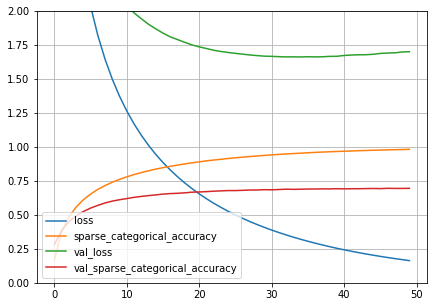

time: 165 ms (started: 2023-02-26 02:17:03 +00:00)


In [27]:
plot_loss(history2)

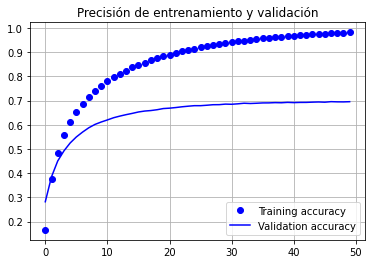

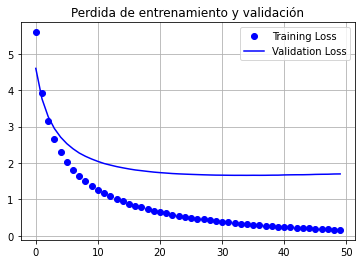

time: 269 ms (started: 2023-02-26 02:17:03 +00:00)


In [28]:
show_history(history2)

In [29]:
save_model(SIZE, TFM_PATH, custom_model2, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/otsu_reg/model_resnet152v2_etl9_imgs127_regular__OTSU.h5
time: 1.82 s (started: 2023-02-26 02:17:03 +00:00)


## Métricas

In [30]:
test_images2, test_labels2 = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.34 s (started: 2023-02-26 02:17:05 +00:00)


In [31]:
show_metrics(custom_model2, test_images2, test_labels2)

1854/1854 [==============================] - 65s 33ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6925126314163208
- Test Loss: 1.7104483842849731
- time: 
- F1 score: 0.6938810277819452
- Precision score: 0.7118398991897091
- Recall:  0.692512647554806
- Epoch: 
*********************************************************************************************************************************
time: 2min 12s (started: 2023-02-26 02:17:08 +00:00)


In [32]:
#runtime.unassign()

time: 314 µs (started: 2023-02-26 02:19:21 +00:00)
